In [91]:
import numpy as np
import pdb
from pandas_plink import read_plink
from limix_lmm import LMM
import pylab as pl

## Download and load genetic data

In [56]:
# load genetic data
bfile = '../data/ALL.chr22_GRCh38.genotypes.20170504'
bim, fam, G = read_plink(bfile)

Mapping files: 100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 11.48it/s]


In [57]:
def extract_region(bim, G, chrom, start, end):
    I1 = bim['chrom']==str(chrom)
    I2 = bim['pos'] > start
    I3 = bim['pos'] < end
    Ikeep = I1 * I2 * I3
    bim = bim.loc[Ikeep].copy()
    G = G[bim['i'].values]
    bim['i'] = np.arange(len(bim))
    return bim, G

In [58]:
def subset_individuals(fam, G, keep_idxs):
    fam = fam.iloc[keep_idxs]
    G = G[:, keep_idxs]
    return bim, G

In [59]:
# subset to 1000 individuals
N = 1000
np.random.seed(0)
idxs = np.sort(np.random.permutation(fam.shape[0])[:N])
fams, Gs = subset_individuals(fam, G, idxs)

In [60]:
# extract region
chrom = 22
start = 30797531
size = 100000
bimr, Gr = extract_region(bim, Gs, chrom, start, start + size)

In [61]:
# load genotype matrix
X = Gr.compute().T

## Simulate pheno, perform local GWAS and compare groundtruth with GWAS results

In [152]:
def simulate_pheno(X, idx_caus, var_expl, direction=None):
    assert len(idx_caus)==len(var_expl)
    
    if direction is None:
        direction = 2. * (np.random.rand(len(idx_caus))>0.5) - 1.
    assert len(idx_caus)==len(direction)
    
    # generate phenotype
    ve = 1 - var_expl.sum()
    assert ve>0, 'sum(var_expl) should be < 1'
    beta = np.sqrt(var_expl) * direction
    Xc = X[:, idx_caus]
    Xc = (Xc - Xc.mean(0)) / Xc.std(0)
    yg = Xc.dot(beta)[:, None]
    yn = np.sqrt(ve) * np.random.randn(X.shape[0], 1)
    y =  yg + yn
    
    # define beta real
    beta_real = np.zeros(X.shape[1])
    beta_real[idx_caus] = beta
    
    # standardize y and renormalize beta_real accordingly
    ystd = y.std()
    y = (y - y.mean()) / ystd
    beta_real = beta_real / ystd
    
    return y, beta_real

In [153]:
# generate phenotype
n_causal = 1
idx_caus = np.random.choice(X.shape[1], size=n_causal)
var_expl = np.array([0.05])
y, beta_real = simulate_pheno(X, idx_caus, var_expl)

In [154]:
# perform genetic association testing 
F = np.ones_like(y)
lmm = LMM(y, F)
lmm.process(X)
pv = lmm.getPv()
beta = lmm.getBetaSNP()
beta_ste = lmm.getBetaSNPste()

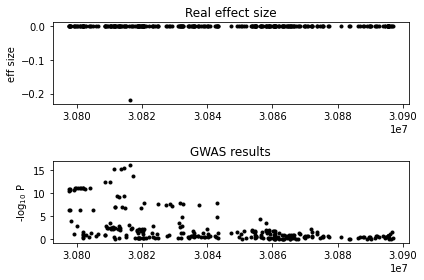

In [155]:
# plot ground truth and results
x = bimr['pos'].values
pl.subplot(211)
pl.title('Real effect size')
pl.plot(x, beta_real, '.k')
pl.ylabel('eff size')
pl.subplot(212)
pl.title('GWAS results')
pl.plot(x, -np.log10(pv), '.k')
pl.ylabel('-log$_{10}$ P')
pl.tight_layout()

## Perform conditional analysis

In [156]:
# first step
F = np.ones_like(y)
lmm = LMM(y, F)
lmm.process(X)
pv0 = lmm.getPv()
idx = np.argmin(pv)

# second step
F = np.concatenate([np.ones_like(y), X[:,[idx]]], 1)
lmm = LMM(y, F)
lmm.process(X)
pv1 = lmm.getPv()

/Users/paolo.casale/miniconda3/lib/python3.9/site-packages/limix_lmm/lmm.py:142: RuntimeWarning: divide by zero encountered in true_divide
  n = 1.0 / (GKiG - sp.einsum("ij,ij->j", FKiG, A0iFKiG))
/Users/paolo.casale/miniconda3/lib/python3.9/site-packages/limix_lmm/lmm.py:143: RuntimeWarning: invalid value encountered in multiply
  M = -n * A0iFKiG


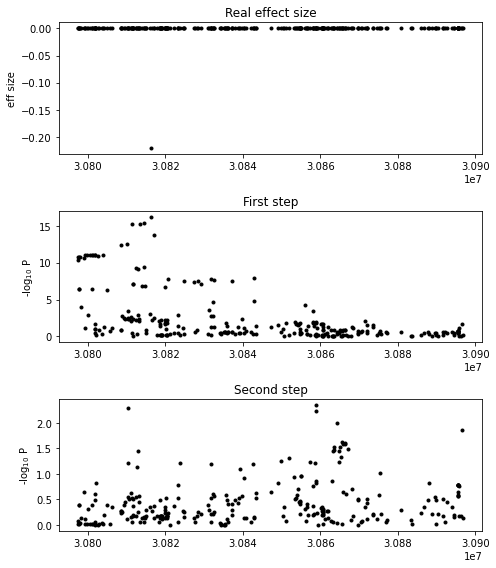

In [157]:
# plot ground truth and results
pl.figure(1, figsize=(7, 8))
x = bimr['pos'].values
pl.subplot(311)
pl.title('Real effect size')
pl.plot(x, beta_real, '.k')
pl.ylabel('eff size')
pl.subplot(312)
pl.title('First step')
pl.plot(x, -np.log10(pv0), '.k')
pl.ylabel('-log$_{10}$ P')
pl.tight_layout()
pl.subplot(313)
pl.title('Second step')
pl.plot(x, -np.log10(pv1), '.k')
pl.ylabel('-log$_{10}$ P')
pl.tight_layout()

## Compute Bayes Factors

$ABF=\sqrt{1-r}\times\text{exp}(\frac12Z^2\times{r})$

$Z=\frac{\beta}{\sqrt{V}}$

$r = \frac{W}{V+W}$

$V=\text{Var}(\hat{\beta}_j)=\frac{1}{N\text{var}(y)2f_j(1-f_j)}$

In [184]:
def compute_ABF1(beta, ste, W=0.15**2):
    V = ste**2
    r = W / (V + W)
    Z = beta / np.sqrt(V)
    ABF = np.sqrt(1 - r) * np.exp(0.5 * Z**2 * r)
    return ABF

In [185]:
# ABF and PIP
ABF = compute_ABF1(beta, beta_ste)
PIP = ABF / ABF.sum()

In [231]:
# Credible set
def compute_cs(PIP):
    idxs = np.argsort(PIP)[::-1]
    _upto = np.where(PIP[idxs].cumsum()>0.95)[0][0] + 1
    Ics = idxs[:_upto]
    return Ics

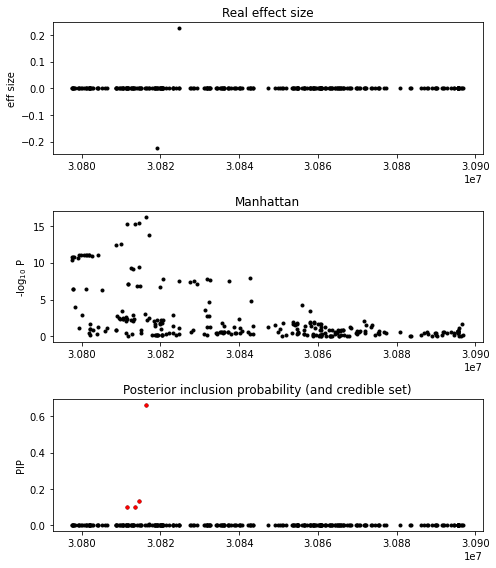

In [232]:
# plot ground truth and results
pl.figure(1, figsize=(7, 8))
x = bimr['pos'].values
pl.subplot(311)
pl.title('Real effect size')
pl.plot(x, beta_real, '.k')
pl.ylabel('eff size')
pl.subplot(312)
pl.title('Manhattan')
pl.plot(x, -np.log10(pv0), '.k')
pl.ylabel('-log$_{10}$ P')
pl.tight_layout()
pl.subplot(313)
pl.title('Posterior inclusion probability (and credible set)')
pl.plot(x, PIP, '.k')
Ics = compute_cs(PIP)
pl.plot(x[Ics], PIP[Ics], '.r')
pl.ylabel('PIP')
pl.tight_layout()

## Susie algorithm based on the SER model

Under the SER model one can show that the posterior probabilities for $b$ and $\boldsymbol{\gamma}$ are

$b|\mathbf{y}, \mathbf{X}, \sigma^2, \sigma^2_0\sim\mathcal{N}(\mu_1, \sigma^2_1)$

$\boldsymbol{\gamma}|\mathbf{y}, \mathbf{X}, \sigma^2, \sigma^2_0\sim\text{Mult}(1, \boldsymbol{\pi})$

Where $\boldsymbol{\pi}$, $\mu_1$ and $\sigma_1^2$ can all be computed from single-variant regression summary stats. Specifically, $\boldsymbol{\pi}$ is the PIP we computed in the previous section. In the following, we provide a function that enables computation of $\boldsymbol{\pi}$, $\mu_1$ and $\sigma_1^2$. We will use this function to implement the full SuSiE algorithm.

In [255]:
# while the full SuSiE algorithm enable optimization of sigma2 and sigma2_0,
# we here consider a version where they have fixed values (priors)
def SER(X, y, sigma2_0=0.15**2, sigma2=1):
    
    # fit single-variant regression model
    F = np.ones_like(y)
    lmm = LMM(y, F)
    lmm.process(X)
    pv = lmm.getPv()
    beta = lmm.getBetaSNP()
    ste = lmm.getBetaSNPste()
    
    # compute pi, mu_1 and sigma2_1
    ABF = compute_ABF1(beta, ste)
    pi = ABF / ABF.sum()
    sigma2_1 = 1 / (1 / ste**2 + 1 / sigma2_0)
    mu_1 = sigma2_1 / ste**2 * beta
    
    return pi, mu_1, sigma2_1

In [260]:
# generate phenotype
n_causal = 2
idx_caus = np.random.choice(X.shape[1], size=n_causal)
var_expl = np.array([0.05, 0.05])
y, beta_real = simulate_pheno(X, idx_caus, var_expl)

In [261]:
# Implement the susie algorithm in slide 28